# HisToGene Benchmark (INT25-INT28)

## 环境配置说明
为了顺利运行此 Notebook，建议创建一个新的 Conda 环境，并安装以下依赖。
旧环境(`scrna`)中似乎存在 `torch-scatter` 兼容性问题导致报错，新环境可以避免此问题。

### 1. 创建并激活新环境
```bash
conda create -n histogene_bench python=3.9
conda activate histogene_bench
```

### 2. 安装 PyTorch 和 Torchvision (请根据你的 CUDA 版本选择)
```bash
# 示例：CUDA 11.8
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
```

### 3. 安装其他必需库
```bash
pip install openslide-python pytorch-lightning scanpy pandas numpy matplotlib seaborn scprep scikit-learn tqdm einops
```

**注意**：
- **OpenSlide**: 在 Windows 上，`openslide-python` 只是 Python 绑定。你还需要下载 [OpenSlide 二进制文件](https://openslide.org/download/) (Windows binaries)，解压后将 `bin` 目录添加到系统的 `PATH` 环境变量中。
- **Torchvision**: 必须安装，用于 `vis_model.py` 中的 ResNet 模型。

---

## 任务描述
本 Notebook 用于对比 Morpho-VC 项目与 HisToGene 方法在相同数据集（INT25-INT28）上的表现。
HisToGene 是一种基于 Vision Transformer 的空间转录组预测方法。

**任务目标**：
1. 加载 HEST 数据（与 `st_mil_hest_multi.ipynb` 一致）。
2. 将数据转换为 HisToGene 所需格式（Patch + Coordinates）。
3. 训练 HisToGene 模型（Train: INT25, INT26; Val: INT27）。
4. 在测试集（INT28）上进行预测。
5. 计算评估指标（MAE, RMSE, Pearson）并保存结果。


In [16]:
import os
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import scanpy as sc
from PIL import Image

# 尝试修复 Windows 下 OpenSlide 找不到 DLL 的问题
if os.name == 'nt':
    # 尝试寻找当前 Conda 环境下的 Library/bin
    conda_prefix = os.environ.get('CONDA_PREFIX')
    curr_python = sys.executable
    # 简单的推断策略
    possible_paths = []
    if conda_prefix:
        possible_paths.append(Path(conda_prefix) / 'Library' / 'bin')
    if curr_python:
        possible_paths.append(Path(curr_python).parent / 'Library' / 'bin')
        possible_paths.append(Path(curr_python).parent / '..' / 'Library' / 'bin')
    
    # 显式添加找到的路径
    for p in possible_paths:
        # Check for either v1 or v0 DLLs
        if p.exists() and ((p / 'libopenslide-1.dll').exists() or (p / 'libopenslide-0.dll').exists()):
            print(f"Found OpenSlide DLL at: {p}")
            try:
                os.add_dll_directory(str(p))
            except AttributeError:
                pass # Python < 3.8
            os.environ['PATH'] = str(p) + os.pathsep + os.environ['PATH']
            break

try:
    import openslide
    HAS_OPENSLIDE = True
    print("OpenSlide imported successfully!")
except ImportError as e:
    print(f"OpenSlide not found ({e}), will use PIL as fallback.")
    HAS_OPENSLIDE = False

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# ====== 关键路径设置 ======
# 假设当前脚本在 benchmark/ 目录下，向上两级是项目根目录
ROOT = Path(os.environ.get('MORPHO_VC_ROOT', '../')).expanduser().resolve()
print(f"ROOT: {ROOT}")

# 添加项目源码路径
sys.path.append(str(ROOT / 'src'))
# 添加 HisToGene 源码路径
hg_src = ROOT / 'benchmark' / 'HisToGene'
sys.path.append(str(hg_src))
# 添加 benchmark 目录以导入 hest_dataset
sys.path.append(str(ROOT / 'benchmark'))

from vis_model import HisToGene
from utils import *

# 数据目录
data_dir = ROOT / 'data'
hest_dir = data_dir / 'hest_data'
spatial_dir = data_dir / 'spatial_data'
result_dir = ROOT / 'benchmark' / 'results' / 'histogene'
result_dir.mkdir(parents=True, exist_ok=True)

# 共同基因列表（需与 st_mil_hest_multi.ipynb 保持一致）
common_gene_path = spatial_dir / 'common_genes.txt'

# 切片 ID
train_ids = ['INT25', 'INT26']
val_ids = ['INT27']
test_ids = ['INT28']

print("Result Directory:", result_dir)

OpenSlide imported successfully!
ROOT: D:\code\Morpho-VC
Result Directory: D:\code\Morpho-VC\benchmark\results\histogene


## 1. 数据集定义

定义 `HESTHisToGeneDataset` 类，用于加载 HEST 数据并适配 HisToGene 模型的输入格式。
- 每次加载一个切片的 patch (根据 h5ad 中的坐标从 WSI 中裁剪)。
- 坐标需要归一化到 HisToGene 的 embedding 范围 (通常是 grid index)。
- 提取共同基因的表达量作为 label。

In [17]:
from hest_dataset import HESTHisToGeneDataset
import scipy.sparse

## 2. 准备数据

In [18]:
# 读取共同基因
with open(common_gene_path, 'r') as f:
    common_genes = f.read().splitlines()
print(f"Common genes count: {len(common_genes)}")

# 参数
PATCH_SIZE = 112 # HisToGene default
N_POS = 64
BATCH_SIZE = 32

# 创建 Dataset
train_ds = HESTHisToGeneDataset(train_ids, hest_dir, spatial_dir, common_genes, patch_size=PATCH_SIZE, n_pos=N_POS, train=True)
val_ds = HESTHisToGeneDataset(val_ids, hest_dir, spatial_dir, common_genes, patch_size=PATCH_SIZE, n_pos=N_POS, train=False)
test_ds = HESTHisToGeneDataset(test_ids, hest_dir, spatial_dir, common_genes, patch_size=PATCH_SIZE, n_pos=N_POS, train=False)

# DataLoader
# Windows 下使用 PIL fallback 时，多进程(num_workers>0)可能会导致巨大的内存开销和速度变慢 (Pickle overhead)
# 因此如果没有 OpenSlide，建议设为 0
workers = 4 
print(f"Using num_workers={workers}")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=workers)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=workers)

Common genes count: 17512
Loading 2 slides...
Total spots: 7702
Loading 1 slides...
Total spots: 4176
Loading 1 slides...
Total spots: 3990
Using num_workers=4


## 3. 模型训练

使用 PyTorch Lightning 训练 HisToGene。

In [19]:
# Create result directory
result_dir.mkdir(parents=True, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='valid_loss',
    dirpath=result_dir,
    filename='histogene_best',
    save_top_k=1,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor="valid_loss",
    min_delta=0.00,
    patience=5,
    verbose=True,
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else 'auto',
    callbacks=[checkpoint_callback, early_stop_callback],
    default_root_dir=result_dir
)

# Check for existing checkpoint to skip training
best_model_path = result_dir / 'histogene_best.ckpt'
train_model = False
model = None # Initialize model variable

if best_model_path.exists():
    print(f"Found existing checkpoint at {best_model_path}. Attempting to load...")
    try:
        # Pass required args because save_hyperparameters() is commented out in model definition
        model = HisToGene.load_from_checkpoint(str(best_model_path),
                                             patch_size=PATCH_SIZE,
                                             n_genes=len(common_genes),
                                             n_pos=N_POS)
        print("Checkpoint loaded successfully. Skipping training.")
        train_model = False
    except Exception as e:
        print(f"Checkpoint loading failed or incompatible ({e}). Proceeding to re-training.")
        train_model = True
else:
    print("No existing checkpoint found. Proceeding to training.")

if train_model:
    print("Starting training...")
    # Initialize model with correct parameters
    model = HisToGene(patch_size=PATCH_SIZE, n_layers=4, n_genes=len(common_genes), dim=1024, learning_rate=1e-4, dropout=0.1, n_pos=N_POS)
    trainer.fit(model, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found existing checkpoint at D:\code\Morpho-VC\benchmark\results\histogene\histogene_best.ckpt. Attempting to load...
Checkpoint loaded successfully. Skipping training.


## 4. 预测与评估

加载最优模型并在测试集上进行预测。

In [20]:
# 加载最优模型 (如果进行了训练)
best_model_path = result_dir / 'histogene_best.ckpt'

if train_model:
    if best_model_path.exists():
        print(f"Loading best model from {best_model_path}")
        try:
            model = HisToGene.load_from_checkpoint(str(best_model_path),
                                                 patch_size=PATCH_SIZE,
                                                 n_genes=len(common_genes),
                                                 n_pos=N_POS)
        except Exception as e:
            print(f"Warning: Could not reload best model ({e}). Using current model state.")
    else:
        print("Warning: Best model checkpoint not found, using current model weights.")
else:
    print("Using already loaded model for prediction.")

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 预测循环
preds = []
truths = []

print("Predicting on Test set...")
with torch.no_grad():
    for batch in test_loader:
        patch, pos, exp = batch
        patch = patch.to(device)
        pos = pos.to(device)
        
        # Forward
        pred_exp = model(patch, pos)
        
        # Safe squeeze sequence dim to get (Batch, n_genes)
        pred_exp_np = pred_exp.cpu().numpy()
        if pred_exp_np.ndim == 3 and pred_exp_np.shape[1] == 1:
            pred_exp_np = pred_exp_np.squeeze(axis=1)
        preds.append(pred_exp_np)
        
        exp_np = exp.numpy()
        if exp_np.ndim == 3 and exp_np.shape[1] == 1:
            exp_np = exp_np.squeeze(axis=1)
        truths.append(exp_np)

pred_bag = np.concatenate(preds, axis=0)
true_bag = np.concatenate(truths, axis=0)

print("Prediction Shape:", pred_bag.shape)

# 保存结果
np.save(result_dir / 'pred_bag.npy', pred_bag)
np.save(result_dir / 'true_bag.npy', true_bag)


Using already loaded model for prediction.
Predicting on Test set...
Prediction Shape: (3990, 17512)


## 5. 指标计算

计算 MAE, RMSE 和 Pearson 相关系数。

In [21]:
def pearson_corr(a, b):
    # Handle constant arrays to avoid division by zero
    if np.all(a == a[0]) or np.all(b == b[0]):
        return np.nan
    a = a - a.mean()
    b = b - b.mean()
    denom = np.sqrt((a * a).sum()) * np.sqrt((b * b).sum())
    if denom == 0:
        return np.nan
    return float((a * b).sum() / denom)

mae = np.mean(np.abs(pred_bag - true_bag))
rmse = np.sqrt(np.mean((pred_bag - true_bag) ** 2))

# 按基因算 Pearson 相关性
gene_corrs = []
for i in range(pred_bag.shape[1]):
    corr = pearson_corr(pred_bag[:, i], true_bag[:, i])
    gene_corrs.append(corr)

# 过滤 NaN
valid = [(i, c) for i, c in enumerate(gene_corrs) if not np.isnan(c)]
mean_gene_corr = float(np.mean([c for _, c in valid])) if valid else float('nan')

# 找相关性最高的基因
best_gene_idx, best_gene_corr = max(valid, key=lambda x: x[1]) if valid else (None, None)
best_gene_name = common_genes[best_gene_idx] if best_gene_idx is not None else "NA"

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'平均 Pearson(按基因): {mean_gene_corr:.4f}')
print(f'相关性最高的基因: {best_gene_name} (Pearson={best_gene_corr:.4f})')

# Save metrics
metrics = {
    'MAE': float(mae),
    'RMSE': float(rmse),
    'Mean_Pearson': float(mean_gene_corr),
    'Best_Gene': best_gene_name,
    'Best_Pearson': float(best_gene_corr) if best_gene_corr is not None else None
}
with open(result_dir / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)


MAE: 0.2129
RMSE: 0.3601
平均 Pearson(按基因): 0.0563
相关性最高的基因: TPM2 (Pearson=0.6516)


Loading spatial data from: D:\code\Morpho-VC\data\spatial_data\INT28.h5ad
Coords Range: X[2884.0, 12363.0], Y[1596.0, 11424.0]
Found WSI: D:\code\Morpho-VC\data\hest_data\wsis\INT28.tif
WSI dims (original): 14528 x 13580
Using pixel-space extent (0..W, H..0) for alignment.


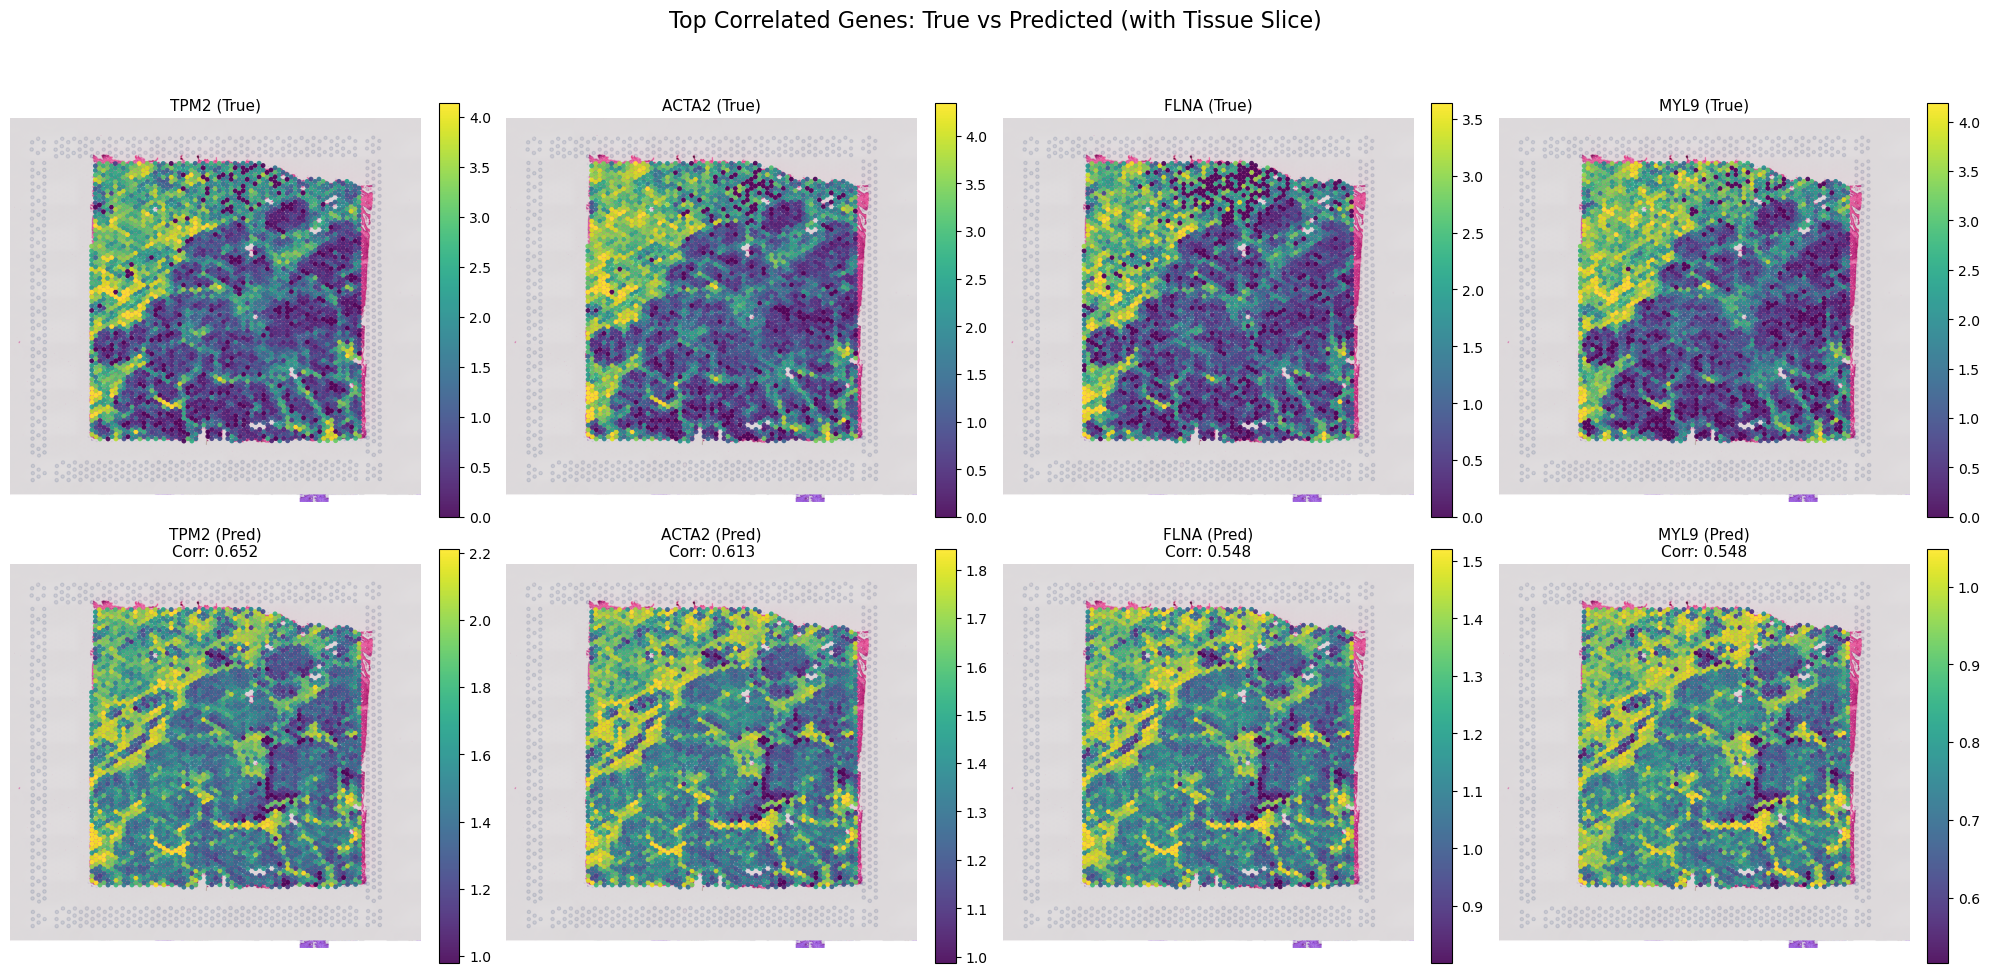

In [22]:
# === Visualizing Spatial Gene-Expression (Top-4) WITH Tissue Slice Background ===
import os
from pathlib import Path

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Optional: background loading
from PIL import Image


def robust_vmin_vmax(arr, p_low=1, p_high=99):
    """
    Compute (vmin, vmax) from *this panel's* values only (robust percentiles).
    Each panel (each subplot) can have its own scale.
    """
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 0.0, 1.0

    vmin, vmax = np.percentile(a, [p_low, p_high])
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(a)), float(np.max(a))
        if vmin == vmax:
            eps = 1e-6 if vmin == 0 else abs(vmin) * 1e-6
            vmin, vmax = vmin - eps, vmax + eps
    return vmin, vmax


# ----------------------------
# 0) Paths & IDs
# ----------------------------
TEST_ID = "INT28"

ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve()
DATA_DIR = ROOT / "data" / "spatial_data"
HEST_DIR = ROOT / "data" / "hest_data"

h5ad_path = DATA_DIR / f"{TEST_ID}.h5ad"
if not h5ad_path.exists():
    # fallback (keep your style)
    h5ad_path = Path(f"../../data/spatial_data/{TEST_ID}.h5ad").resolve()

print(f"Loading spatial data from: {h5ad_path}")

# ----------------------------
# 1) Load spatial coords
# ----------------------------
try:
    adata = sc.read_h5ad(h5ad_path)
    coords = adata.obsm["spatial"]  # shape (N, 2)
    x, y = coords[:, 0], coords[:, 1]

    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    print(f"Coords Range: X[{min_x:.1f}, {max_x:.1f}], Y[{min_y:.1f}, {max_y:.1f}]")
except Exception as e:
    print(f"[ERROR] Failed to load spatial coords: {e}")
    # last-resort fallback for debugging
    x, y = np.random.rand(pred_bag.shape[0]), np.random.rand(pred_bag.shape[0])
    min_x, min_y, max_x, max_y = x.min(), y.min(), x.max(), y.max()

# ----------------------------
# 2) Try load WSI background (tissue slice)
# ----------------------------
bg_img = None
bg_extent = None  # (xmin, xmax, ymax, ymin) or (xmin, xmax, ymin, ymax) depending on usage

wsi_files = list((HEST_DIR / "wsis").glob(f"{TEST_ID}.*"))
if len(wsi_files) > 0:
    wsi_path = wsi_files[0]
    print(f"Found WSI: {wsi_path}")

    # Try OpenSlide first (best for .svs/.tiff)
    try:
        import openslide  # noqa: F401

        slide = openslide.OpenSlide(str(wsi_path))
        w0, h0 = slide.dimensions
        print(f"WSI dims (original): {w0} x {h0}")

        # build a thumbnail for plotting speed
        thumb_w = 2000
        scale = thumb_w / w0
        thumb_h = int(h0 * scale)
        bg_img = slide.get_thumbnail((thumb_w, thumb_h))

        # Decide extent strategy:
        # If coords look like they live in pixel space [0..w0, 0..h0], use pixel extent.
        # Else, stretch thumbnail into coords bounding box (still gives a tissue-context background).
        in_pixel_space = (
            (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
            (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
        )

        if in_pixel_space:
            # same convention as your reference code: y-down image coordinates
            bg_extent = (0, w0, h0, 0)
            print("Using pixel-space extent (0..W, H..0) for alignment.")
        else:
            bg_extent = (min_x, max_x, max_y, min_y)
            print("Coords not in pixel space; stretching background to coords bounding box.")

    except Exception as e:
        print(f"OpenSlide failed ({e}), trying PIL...")

        try:
            Image.MAX_IMAGE_PIXELS = None
            img = Image.open(wsi_path)
            w0, h0 = img.size
            print(f"WSI dims (PIL original): {w0} x {h0}")

            img.thumbnail((2000, 2000))
            bg_img = img

            in_pixel_space = (
                (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
            )
            if in_pixel_space:
                bg_extent = (0, w0, h0, 0)
                print("Using pixel-space extent (0..W, H..0) for alignment.")
            else:
                bg_extent = (min_x, max_x, max_y, min_y)
                print("Coords not in pixel space; stretching background to coords bounding box.")
        except Exception as e2:
            print(f"[WARNING] PIL background load failed: {e2}")
            bg_img, bg_extent = None, None
else:
    print("[INFO] No WSI found under:", (HEST_DIR / "wsis"))

# ----------------------------
# 3) Pick Top-4 genes by correlation (valid: list of (idx, corr))
# ----------------------------
sorted_genes = sorted(valid, key=lambda t: t[1], reverse=True)
top4_genes = sorted_genes[:4]
n_show = len(top4_genes)
if n_show == 0:
    raise ValueError("top4_genes is empty. Check `valid` content.")

# ----------------------------
# 4) Plot (2 rows: True vs Pred) + background slice
#    - ✅ NO shared scaling: each panel (each subplot) has its own vmin/vmax
# ----------------------------
fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
if n_show == 1:
    # keep axes 2D: axes[row, col]
    axes = np.array(axes).reshape(2, 1)

fig.suptitle("Top Correlated Genes: True vs Predicted (with Tissue Slice)", fontsize=16, y=0.98)

for i, (gene_idx, corr) in enumerate(top4_genes):
    gene_name = common_genes[gene_idx]

    gt_expr = true_bag[:, gene_idx]
    pr_expr = pred_bag[:, gene_idx]

    # ✅ Panel-wise dynamic range (robust to outliers)
    vmin_gt, vmax_gt = robust_vmin_vmax(gt_expr, p_low=1, p_high=99)
    vmin_pr, vmax_pr = robust_vmin_vmax(pr_expr, p_low=1, p_high=99)

    # --- Row 1: Ground Truth ---
    ax_gt = axes[0, i]
    if bg_img is not None and bg_extent is not None:
        ax_gt.imshow(bg_img, extent=bg_extent)
    sc_gt = ax_gt.scatter(
        x, y, c=gt_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_gt, vmax=vmax_gt, edgecolors="none"
    )
    ax_gt.set_title(f"{gene_name} (True)", fontsize=11)
    ax_gt.axis("off")
    if bg_img is None:
        ax_gt.invert_yaxis()
    plt.colorbar(sc_gt, ax=ax_gt, fraction=0.046, pad=0.04)

    # --- Row 2: Prediction ---
    ax_pr = axes[1, i]
    if bg_img is not None and bg_extent is not None:
        ax_pr.imshow(bg_img, extent=bg_extent)
    sc_pr = ax_pr.scatter(
        x, y, c=pr_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_pr, vmax=vmax_pr, edgecolors="none"
    )
    ax_pr.set_title(f"{gene_name} (Pred)\nCorr: {corr:.3f}", fontsize=11)
    ax_pr.axis("off")
    if bg_img is None:
        ax_pr.invert_yaxis()
    plt.colorbar(sc_pr, ax=ax_pr, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
